In [1]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
plt.rcParams['figure.figsize'] = [20, 8]

In [2]:
#Load dataset
df = pd.read_csv('../../Dataset/Platinum.csv')
df = df.reset_index()['Close']
df

0        930.5
1        945.5
2        957.0
3        964.0
4        969.5
         ...  
2339    1059.5
2340    1040.5
2341    1031.5
2342    1038.5
2343    1038.5
Name: Close, Length: 2344, dtype: float64

In [3]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df).reshape(-1, 1))

In [4]:
# 4. Split train and test data
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
# 5. Function to create dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [6]:
# 6. Create train and test datasets
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [8]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(32))
model.add(Dense(1))

In [9]:
#Use Adam optimizer with learning rate = 0.001
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='mean_squared_error')

In [10]:
#9. Fit model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1, callbacks=[early_stop])

Epoch 1/100
28/28 [==============================] - 113s 1s/step - loss: 0.0366 - val_loss: 0.0035
Epoch 2/100
28/28 [==============================] - 11s 387ms/step - loss: 0.0035 - val_loss: 8.2638e-04
Epoch 3/100
28/28 [==============================] - 11s 400ms/step - loss: 0.0016 - val_loss: 6.7649e-04
Epoch 4/100
28/28 [==============================] - 11s 389ms/step - loss: 9.5114e-04 - val_loss: 5.8909e-04
Epoch 5/100
28/28 [==============================] - 13s 486ms/step - loss: 7.7801e-04 - val_loss: 5.6304e-04
Epoch 6/100
28/28 [==============================] - 11s 379ms/step - loss: 7.3687e-04 - val_loss: 5.4033e-04
Epoch 7/100
28/28 [==============================] - 9s 336ms/step - loss: 7.0567e-04 - val_loss: 5.3169e-04
Epoch 8/100
28/28 [==============================] - 12s 437ms/step - loss: 6.8160e-04 - val_loss: 4.7921e-04
Epoch 9/100
28/28 [==============================] - 15s 542ms/step - loss: 6.4859e-04 - val_loss: 4.6136e-04
Epoch 10/100
28/28 [=========

In [11]:
# 10. Predict test data
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

12/12 [==============================] - 5s 43ms/step


In [12]:
# 11. Inverse transform test data
train_data1 = df[:train_size]
test_data1 = df[train_size:]
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

In [13]:
# 12. Evaluate model accuracy
test_mse = mean_squared_error(y_test1[time_step + 1:], y_pred)
print('Testing MSE:', test_mse)

test_rmse = math.sqrt(test_mse)
print('Testing RMSE:', test_rmse)

test_mape = mean_absolute_percentage_error(y_test1[time_step + 1:], y_pred)
print('Testing MAPE:', test_mape)

Testing MSE: 276.63196627982745
Testing RMSE: 16.632256800561596
Testing MAPE: 0.013439412823772479


In [14]:
# 13. Define prediction function
def predict(n_steps, temp_input_1, x_input_1, model, day_predict):
    lst_output = []
    temp_input = temp_input_1.copy()
    x_input = x_input_1.copy()
    i = 0
    
    while(i < day_predict):
        if(len(temp_input) > n_steps):
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

In [15]:
# Predict next 30, 60, 90 days
n_steps = 100
x_input = test_data[len(test_data) - n_steps:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_30 = predict(n_steps, temp_input, x_input, model, 30)
lst_output_60 = predict(n_steps, temp_input, x_input, model, 60)
lst_output_90 = predict(n_steps, temp_input, x_input, model, 90)

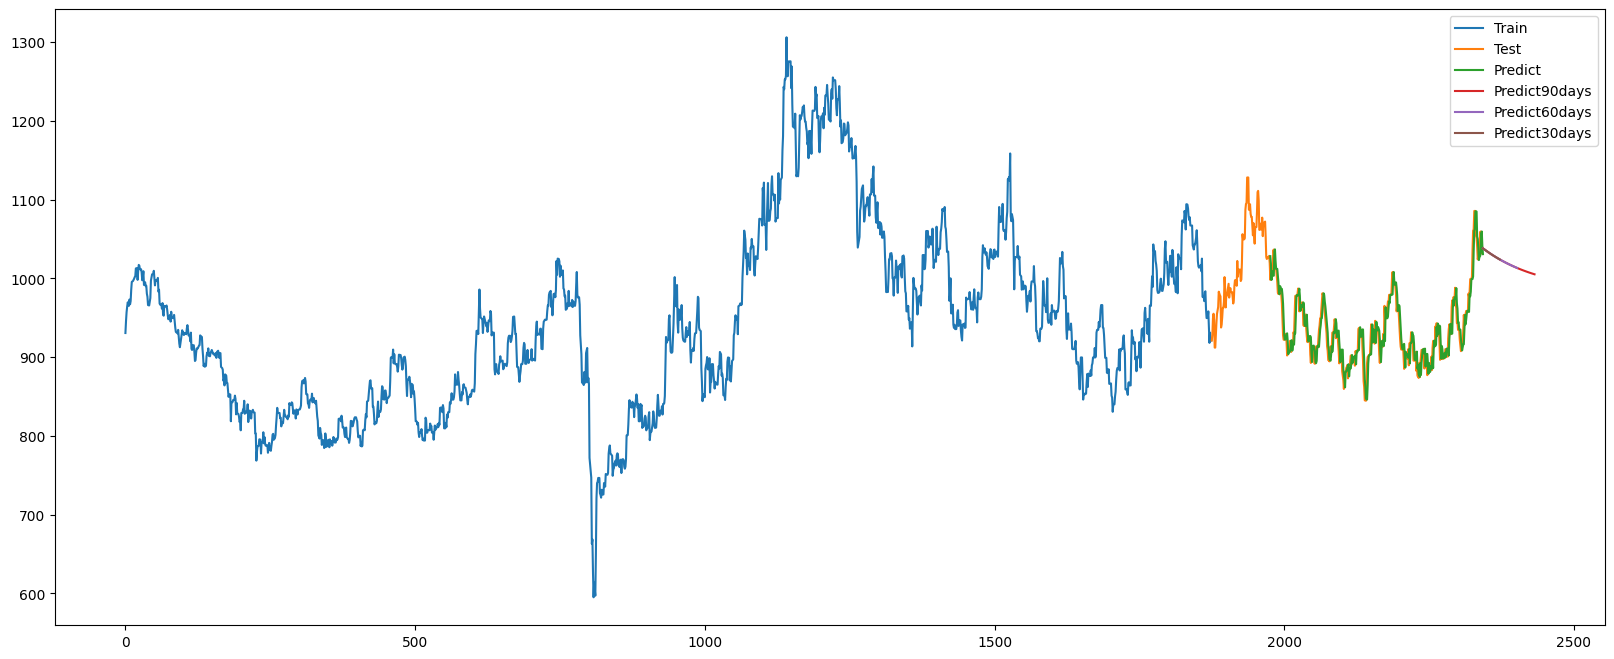

<Figure size 1600x900 with 0 Axes>

In [16]:
#Plot results
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_90))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_60))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_30))

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
plt.figure(figsize=(16,9))
plt.show()